# EPhys Data Analysis Tutorial

This tutorial demonstrates a step-by-step approach to processing electrophysiology (EPhys) data for analysis using Meghan's multirecording_spikeanalysis script, the RCE Pilot 2 behavior spreadsheet, and directories of phy folders (with spike_times.npy, spike_clusters.npy, & cluster_group.tsv) for each ephys recording.

## Setup

Import all the libraries you'll be using, including Meghan's multirecording_spikeanalysis.py:

In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import multirecording_spikeanalysis as spike

## Data Loading
First, we load the relevant EPhys data from the RCE Pilot 2 spreadsheet:

In [2]:
cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

## Preprocessing

Next, we rearrange the spreadsheet in order for it to prepare it for ephys recordings:

In [3]:
df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

## Data Structuring
We'll structure the data into a new DataFrame that aligns with our analysis goals:

In [4]:
# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

## Timestamp Dictionary Preparation
Prepare dictionaries of event timestamps to match with the ephys recordings:

In [5]:
# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

## EPhys Recording Collection
Load EPhys recordings:

In [6]:
# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'all_non_novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class

## Assign Dictionaries to Collection
Create dictionaries for each recording, and assign it and the subject number to the recording:

In [7]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

### (Optional) Save the ephys_data for later use:
If you don't, you'll have to redo the previous steps each time you want to do an analysis:

In [8]:
# pickle.dump(ephys_data, open("ephys_data.pkl", "wb"))

### To import the pickle you can use this:

In [9]:
# ephys_data = pickle.load(open('ephys_data.pkl', 'rb'))

## Analysis Initialization
Finally, initialize the spike analysis with the organized EPhys data (it would be nice to pickle this, but even with 4 CPUs & 64 GB RAM, it still crashed trying to pickle):

In [10]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


### Now you can do functions like:

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal ap

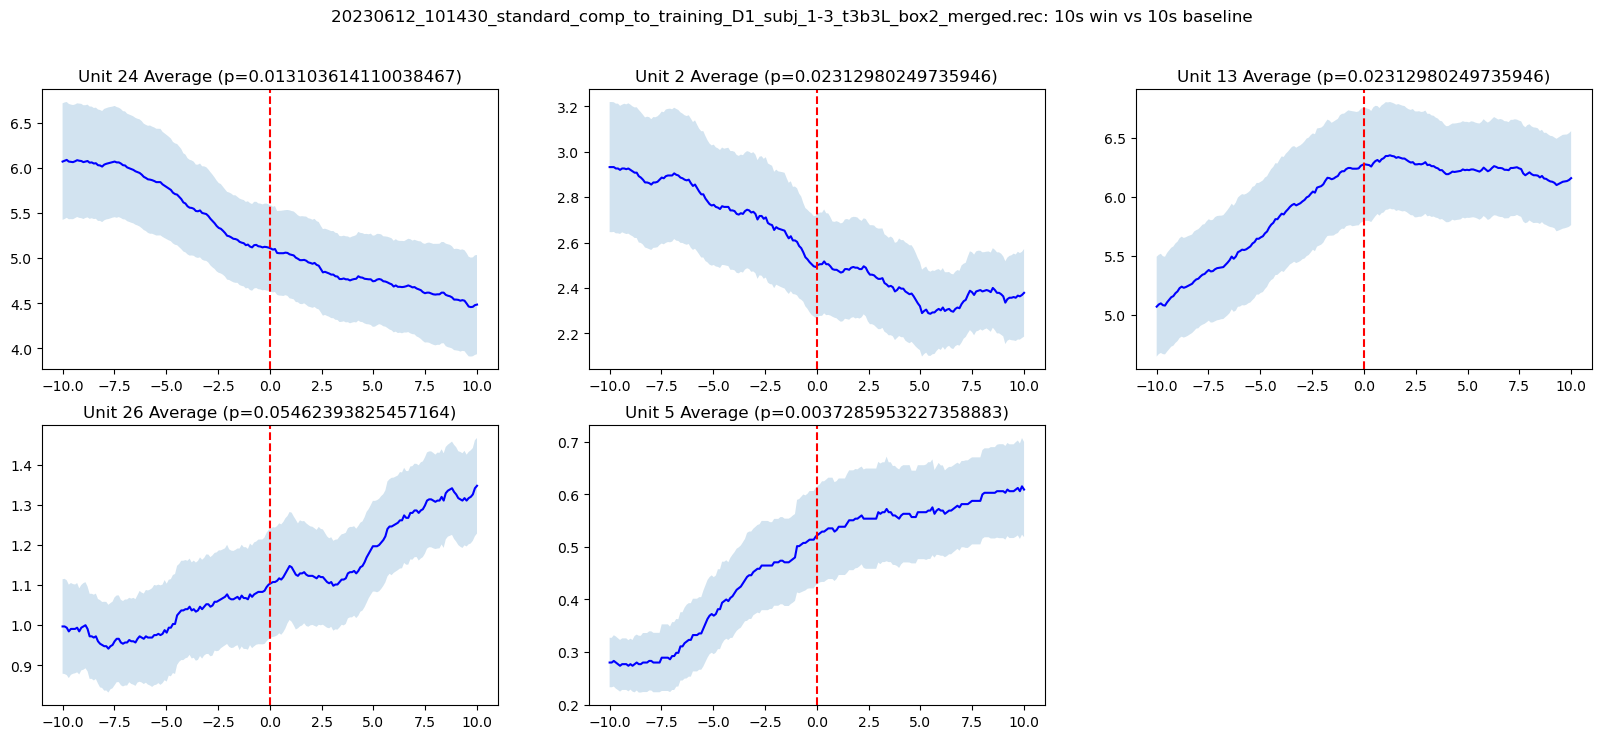

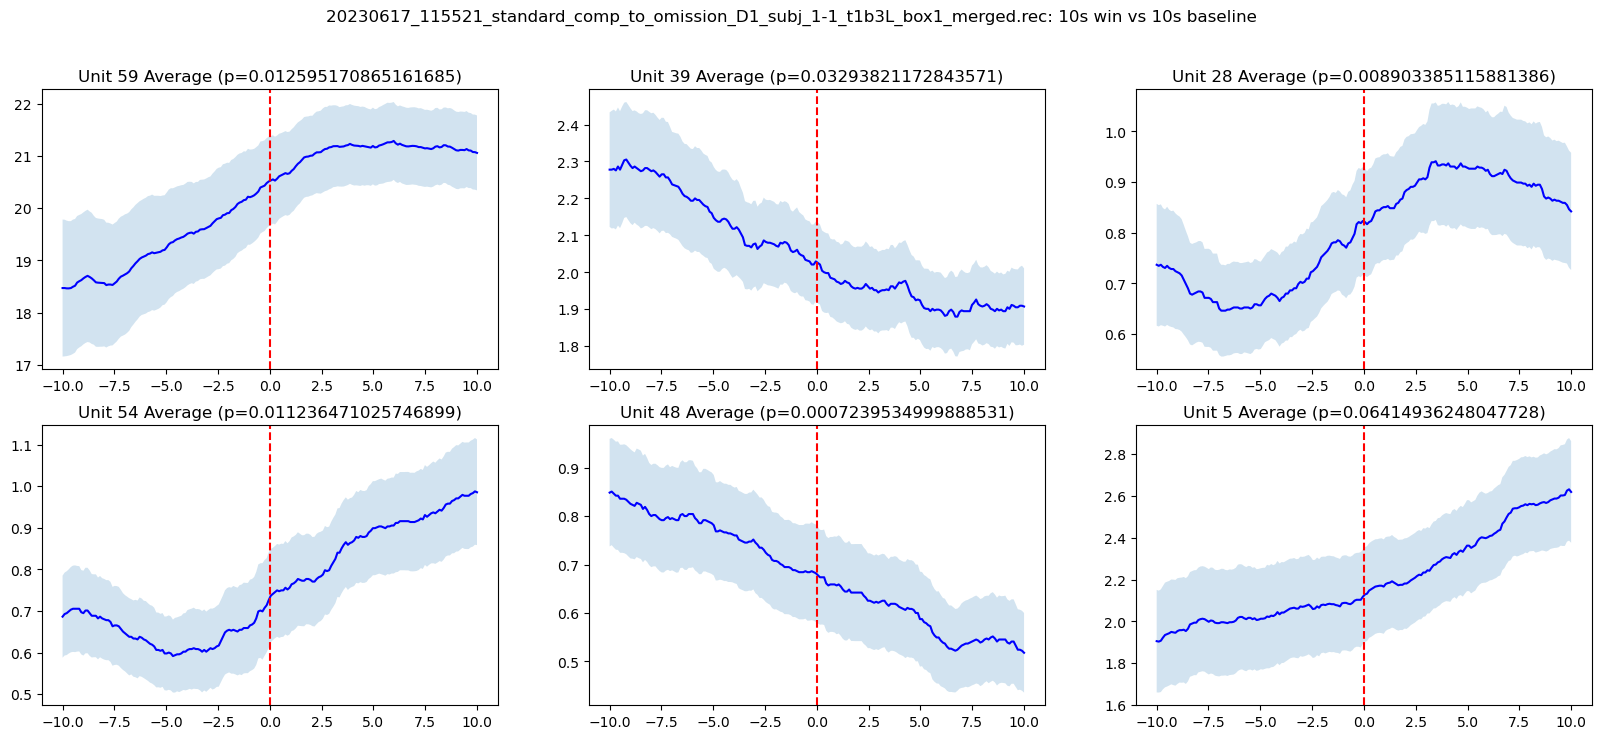

<Figure size 2000x0 with 0 Axes>

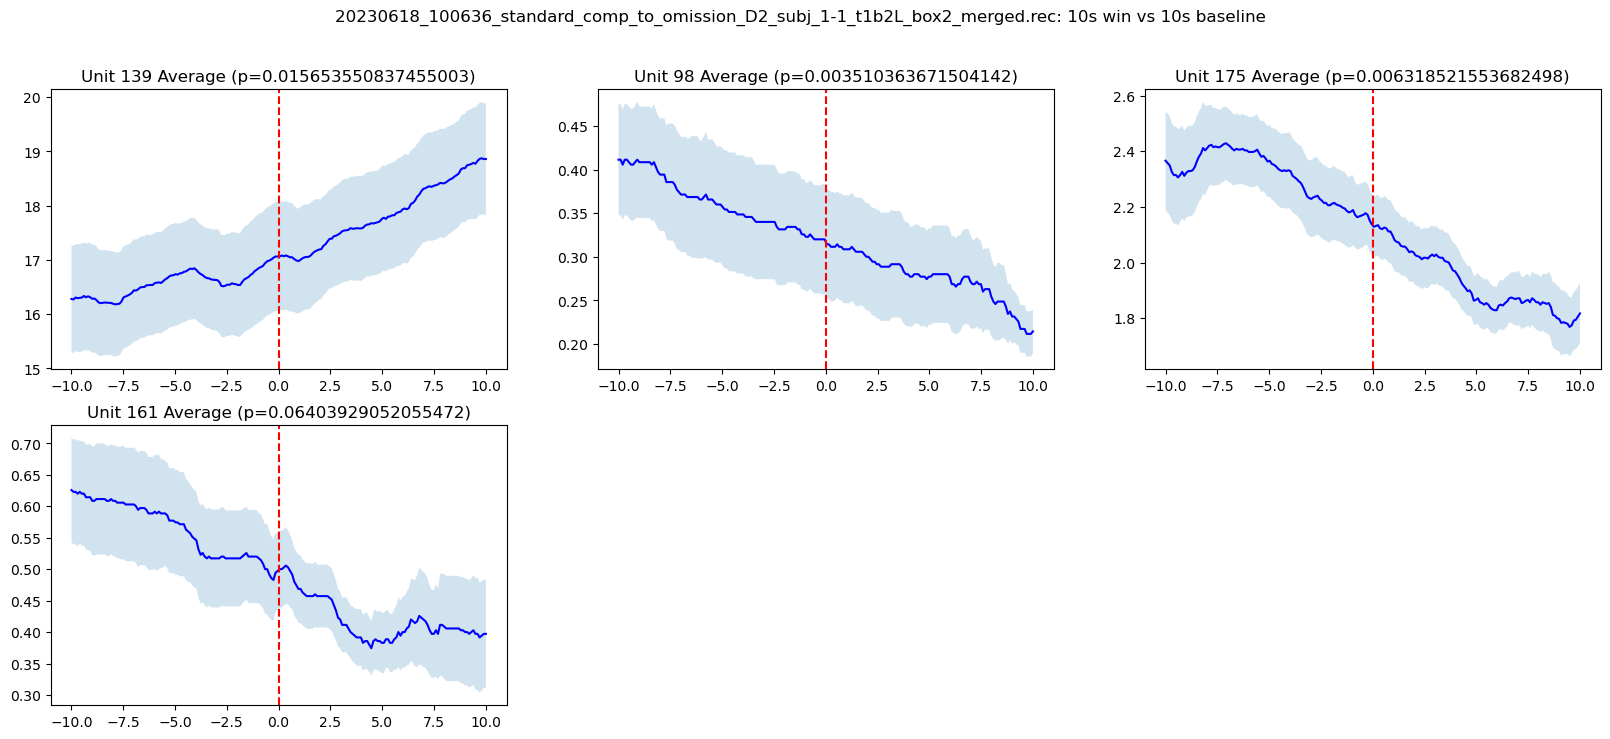

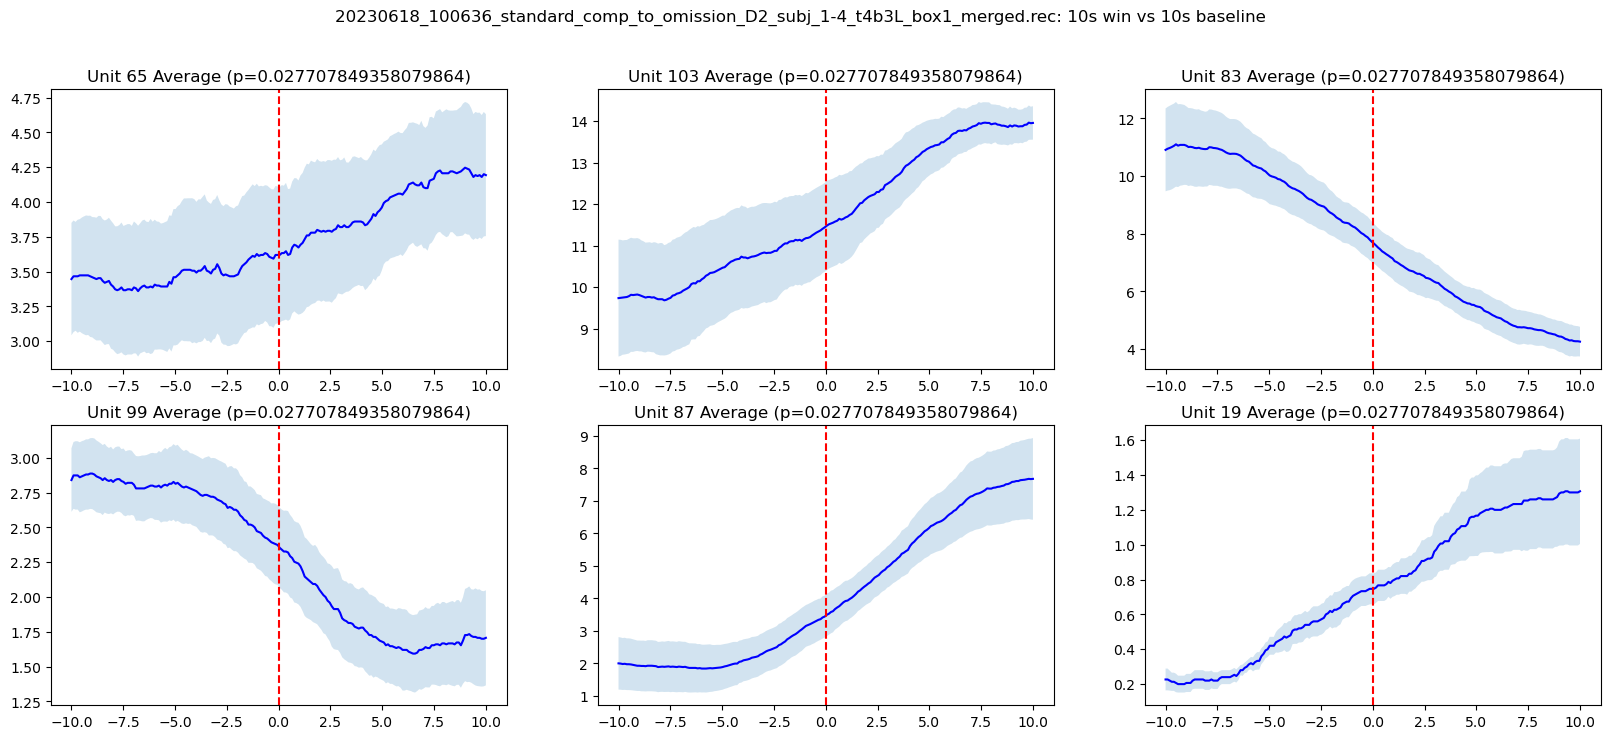

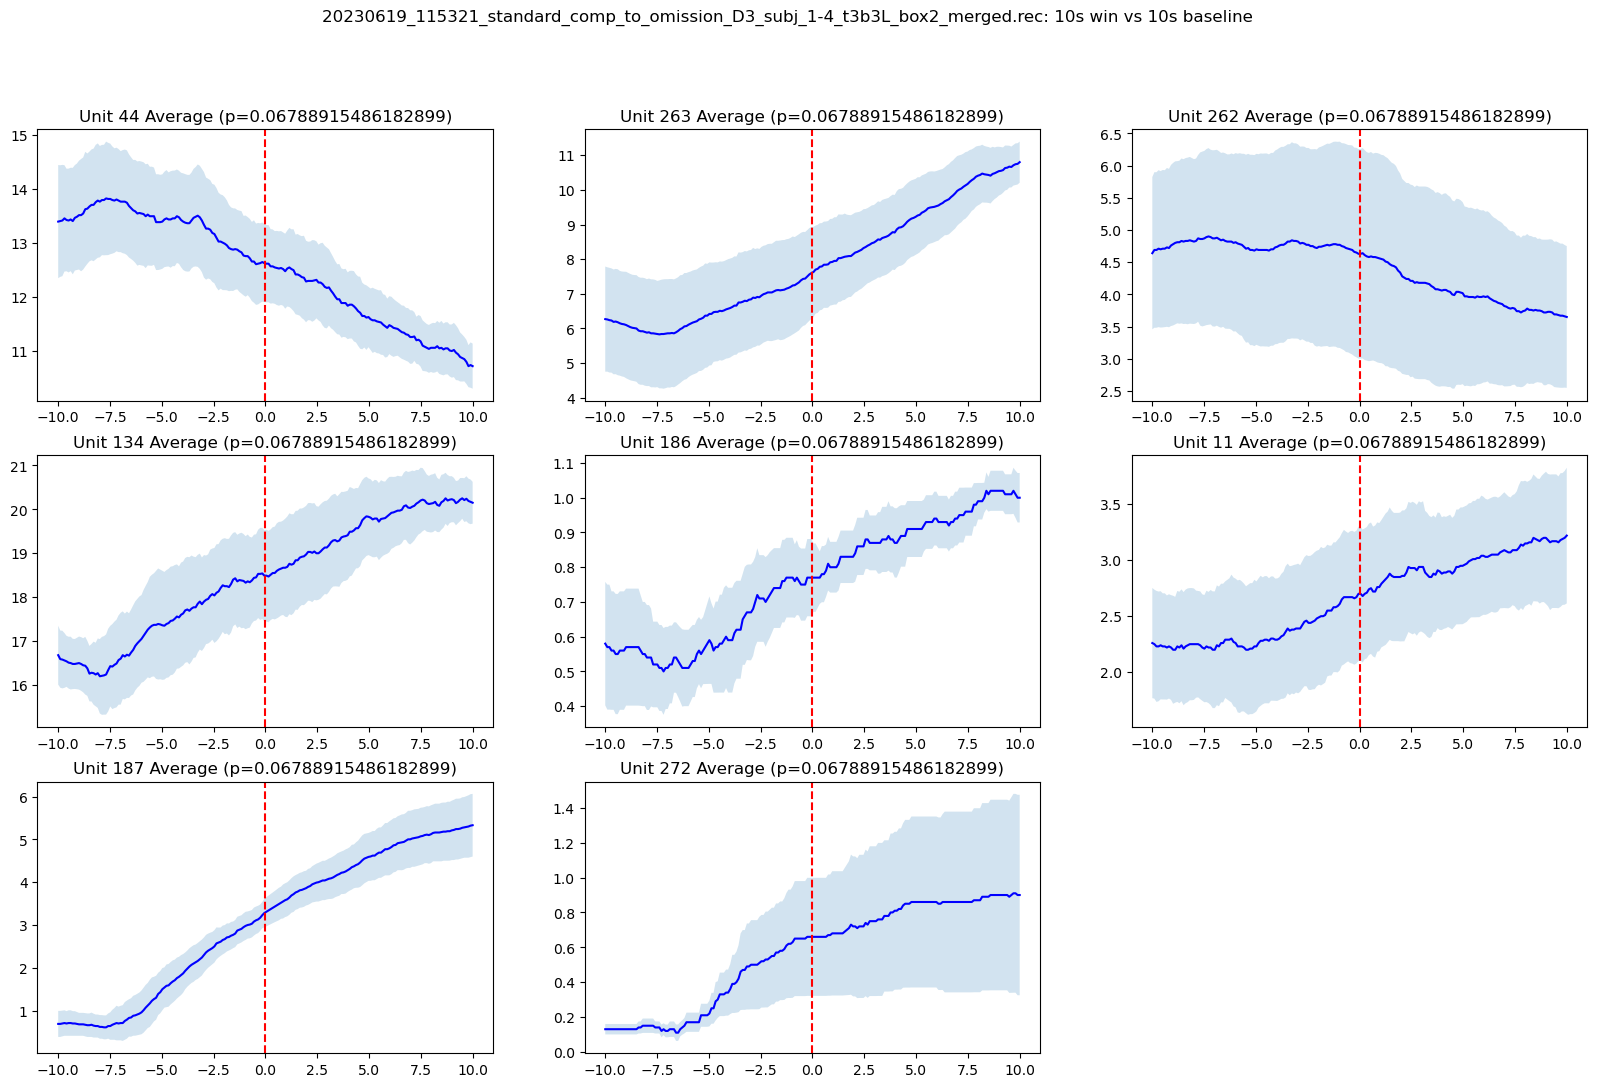

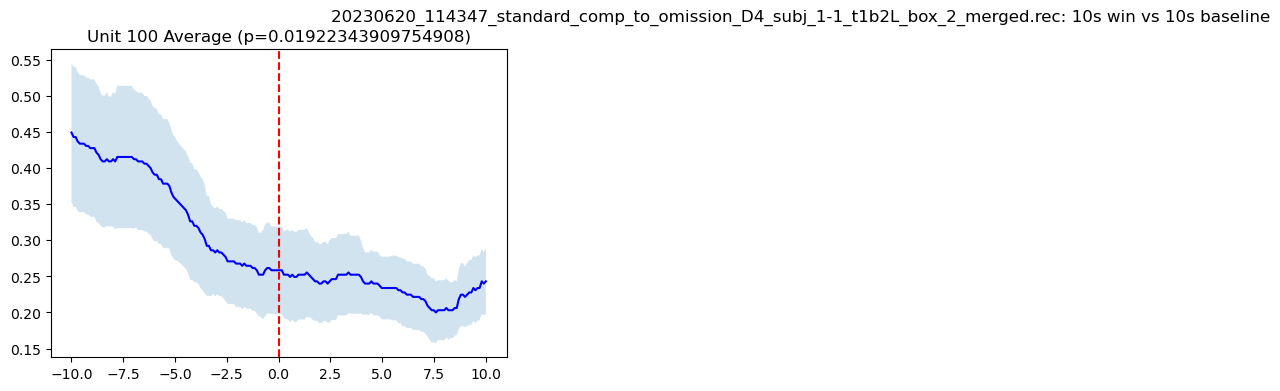

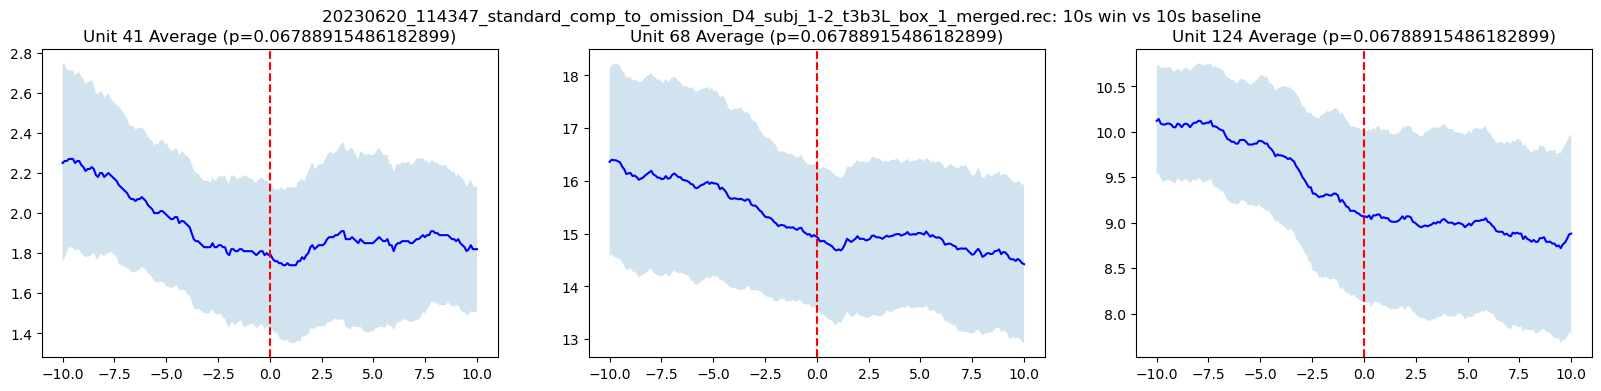

<Figure size 2000x0 with 0 Axes>

<Figure size 2000x0 with 0 Axes>

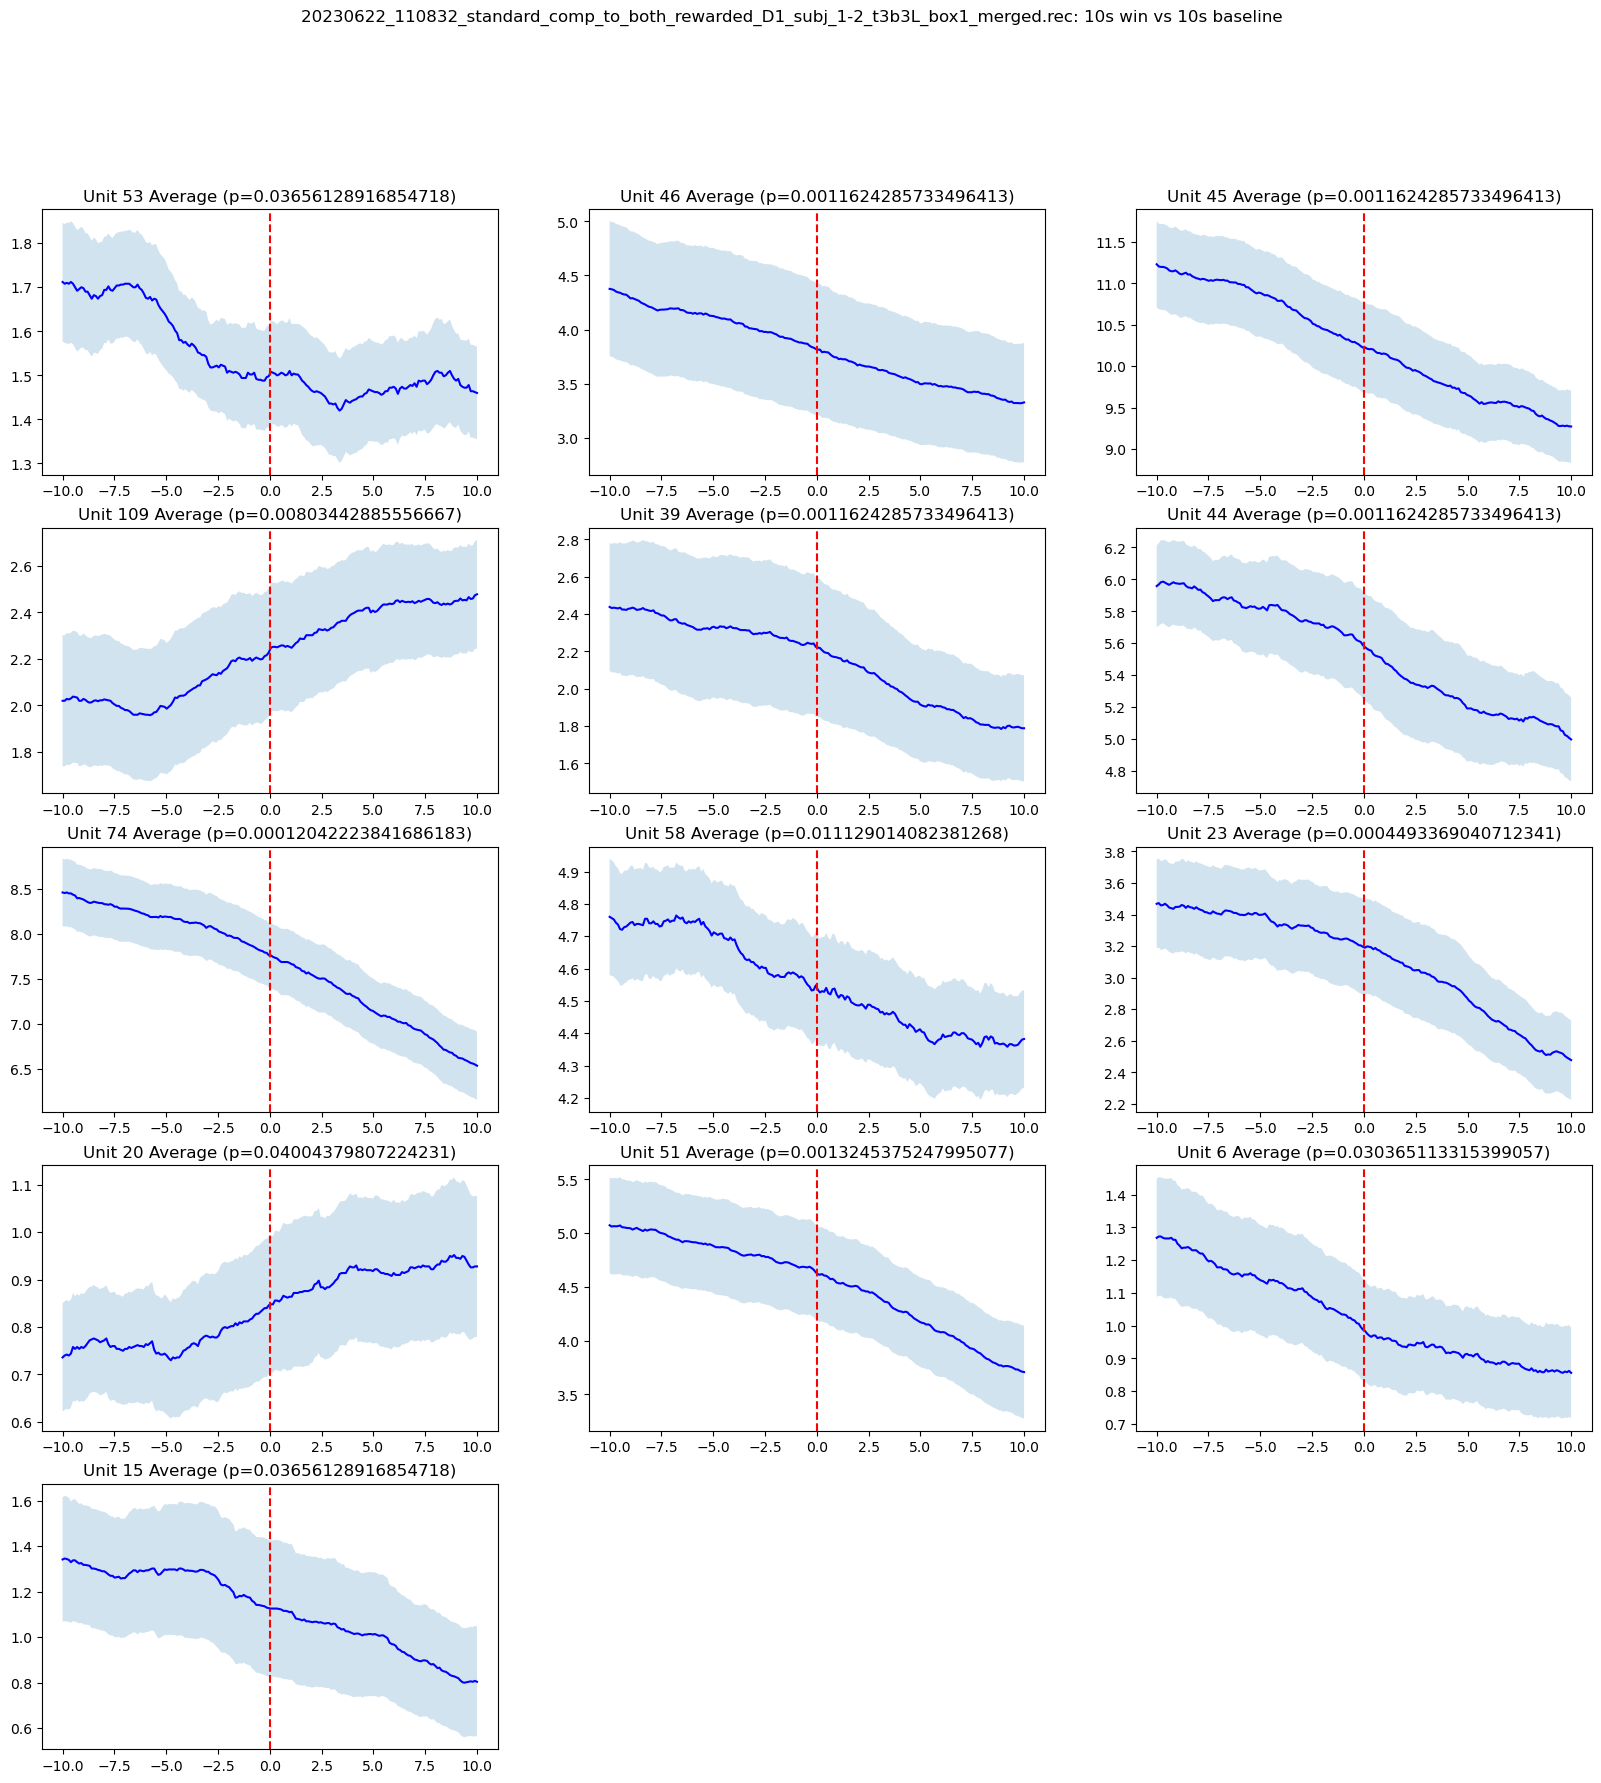

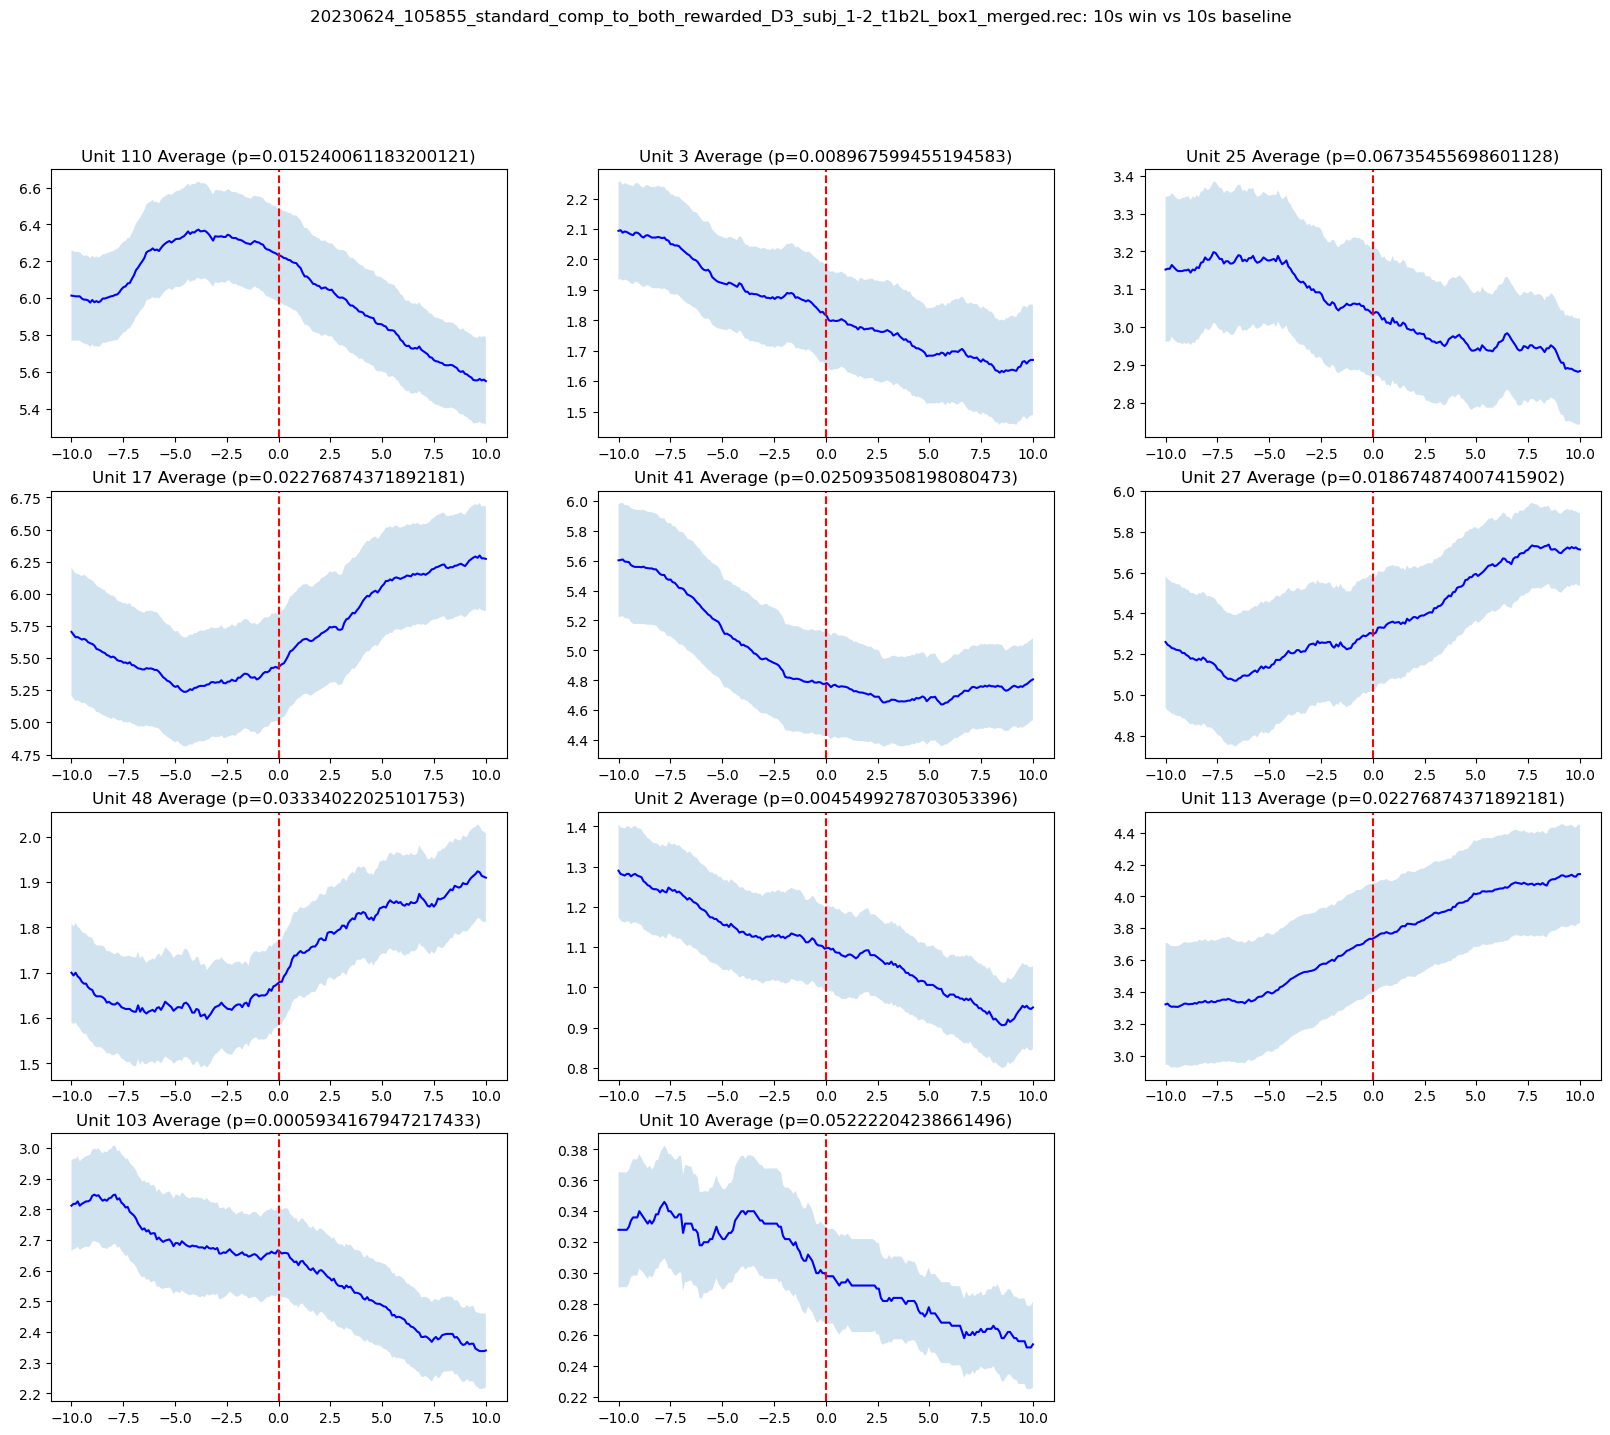

<Figure size 2000x0 with 0 Axes>

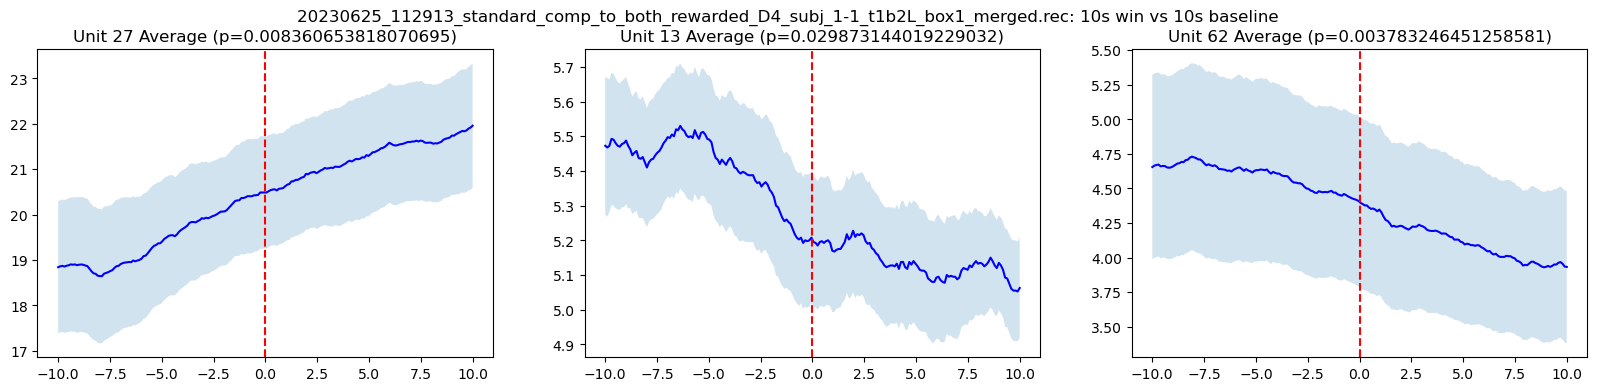

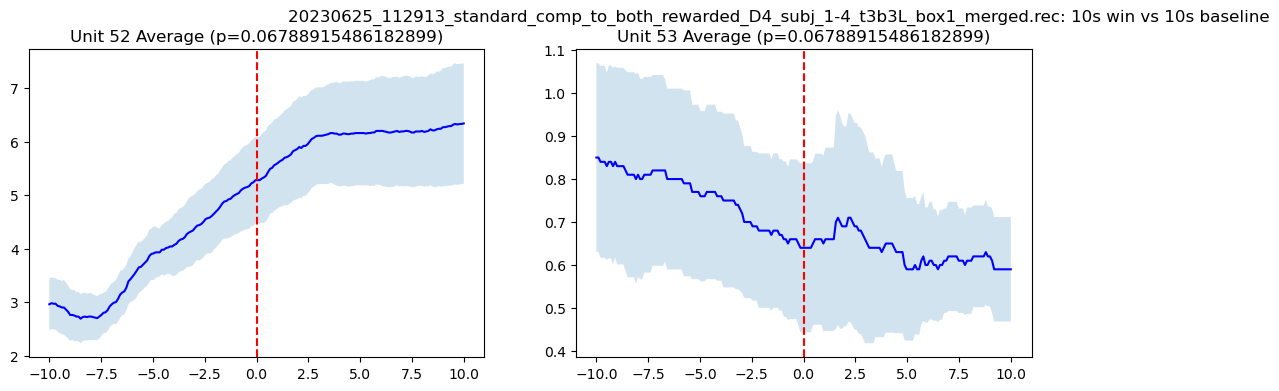

,original unit id,Wilcoxon Stat,p value,event1 vs event2,Recording,Subject,Event
0,85,30.0,0.278707,not significant,20230612_101430_standard_comp_to_training_D1_s...,1-3,10s win vs 10s baseline
1,55,31.5,0.327729,not significant,20230612_101430_standard_comp_to_training_D1_s...,1-3,10s win vs 10s baseline
2,17,28.0,0.221330,not significant,20230612_101430_standard_comp_to_training_D1_s...,1-3,10s win vs 10s baseline
3,24,10.0,0.013104,increases,20230612_101430_standard_comp_to_training_D1_s...,1-3,10s win vs 10s baseline
4,68,27.0,0.196051,not significant,20230612_101430_standard_comp_to_training_D1_s...,1-3,10s win vs 10s baseline
...,...,...,...,...,...,...,...
279,39,4.0,0.715001,not significant,20230625_112913_standard_comp_to_both_rewarded...,1-4,10s win vs 10s baseline
280,17,2.0,0.273322,not significant,20230625_112913_standard_comp_to_both_rewarded...,1-4,10s win vs 10s baseline
281,15,3.0,0.465209,not significant,20230625_112913_standard_comp_to_both_rewarded...,1-4,10s win vs 10s baseline
282,27,2.0,0.273322,not significant,20230625_112913_standard_comp_to_both_rewarded...,1-4,10s win vs 10s baseline


In [11]:
spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10)

### Or to save the DataFrame, something like:
wilcox_wins = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10)